In [1]:
# vidi beleske za pseudokod PSO algoritma i objasnjenje
# PSO je prirodnije koristiti za kontinualnu optimizaciju. Ne moze tek tako da se primeni na diskretne
# (ali ima navodno na repozitorijumu od prosle godine primer kako bi se to radilo)

# Recimo da je problem da nadjemo minimum neke funkcije na nekom intervalu [lb, ub]
# ne mozemo bas da uzmemo neki random primer za ovo jer ce svaki grafik te funkc biti jednostavan
# mozemo da udjemo na wikipediju i da nadjemo test functions for optimization i odatle da uzmemo neku
# npr Rastrigin funkciju (koja ima gomilu lokalnih minimuma)
# Recimo da ako vektor brzine hoce da nas izbaci iz tog itnervala, da cemo da smanjimo intenzitet vektora
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# ovako cemo zadavati prostor pretrage 
# bounds = [(lbx, ubx), (lby, uby), (lbz, ubz), ....]
# ove brojeve smo videli na wikipediji za rastrigin funkciju  (radimo ovde u 2 ndimenzije)
bounds = [(-5.12, 5.12), (-5.12, 5.12)]

In [3]:
# ovo samo implementiramo funkcije koju smo nasli na wikipediji za testiranje
# pise tamo is ta su ocekivana resenja
def rastrigin(x):
    A = 10
    n = len(x)
    return A*n + sum(x_i ** 2 - A * np.cos(2 * np.pi * x_i) for x_i in x)

def rosenbrock(x):
    a = 1
    b = 100
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2 

In [4]:
class Particle:
    
    # najbolja nadjena do sad. Ne mora ovako da se cuva kao static u klasi, to radimo ovde bez nekog razloga
    globalBestPosition = None
    globalBestValue = None
    
    # obj func ce biti neka funkcija ciji minimum trazimo, npr rastrigin itd...
    # ci, cl, cg su oni parametri (u literaturi se zovu i w, c1, c2)
    def __init__(self, bounds, obj_func, c_i, c_l, c_g):
        self.bounds = bounds
        self.obj_func = obj_func
        self.c_i = c_i
        self.c_l = c_l
        self.c_g = c_g
        # pocetna pozicija ce uzeti random broj iz svakog intervala tj dimenzije
        self.position = np.array([random.uniform(bound[0], bound[1]) for bound in bounds])
        # maksimalna brzina koju neka cestica moze da dostigne ce biti maxv = (ub-lb)
        # a minimalna ce biti minv = -maxv
        # mozem pocetnubrzinu i da stavimo na 0, ali ovde za primer koristimo random
        self.velocity = np.array([random.uniform(-(bound[1] - bound[0]), (bound[1] - bound[0])) for bound in bounds])
        # ovo je lokalno/licno najbolje nadjemo resenje za konkretnu cesticu
        self.bestPosition = np.array(self.position)
        self.currValue = obj_func(self.position)
        self.bestValue = self.currValue  # ovo je samo na pocetku jednako sa current
        
        # mozemo ovako da inic na pocetku , nije bitno
        if Particle.globalBestValue == None or self.currValue < Particle.globalBestValue:
            Particle.globalBestPosition = self.position.copy()
            Particle.globalBestValue = self.currValue
    
    def updatePosition(self):
        # pravili smo position i velocity kao numpy liste jer za njih imamo zghodan overloadovani +
        # operator koji sabira po pozicijama, sto nam treba jer sabiramo vektore
        # proverimo da li smo izasli iz opsega [lb, ub] i skratimo ako jeste, np.clip bas radi to
        # (bitno je da proverimo za svaku dimenziju!!)
        lower_bounds = np.array([x[0] for x in self.bounds])
        upper_bounds = np.array([x[1] for x in self.bounds])
        self.position = np.clip(self.position + self.velocity, lower_bounds, upper_bounds)
        # moglo je i kao ispod na klasican nacin
#         for i in range(len(self.position)):
#             self.position[i] = self.position[i] + self.velocity[i]
#             if self.position[i] < self.bounds[i][0]:
#                 self.position[i] = self.bounds[i][0]
#             elif self.position[i] > self.bounds[i][1]:
#                 self.position[i] = self.bounds[i][1]
        
        self.currValue = self.obj_func(self.position)
        if self.bestValue > self.currValue:
            self.bestValue = self.currValue
            self.bestPosition = self.position.copy()   # copy da nebi bila samo referenca
            if self.currValue < Particle.globalBestValue:
                Particle.globalBestValue = self.currValue
                Particle.globalBestPosition = self.position.copy()
        
    def updateVelocity(self):
        # vidi u beleskama sta su ovi r-ovi
#         r_l = random.random()
#         r_g = random.random()

        # Moze i ovako random broj za svaku dimenziju (mozda bude bolji rezultat jer je veca randomizacija)
        r_l = np.random.random(self.velocity.shape)
        r_g = np.random.random(self.velocity.shape)
        
        # ako pravimo vektore za r_l/g imamo mnozenje 2 vektora u numpyju je po koordinatama sto nam i treba 
        self.velocity = (self.c_i * self.velocity
                        + r_l * self.c_l * (self.bestPosition - self.position)           # ovo se zove i cognitive velocity
                        + r_g * self.c_g * Particle.globalBestPosition - self.position)  # ovo se zove i social velocity
        # NOTE: za cognitive i social velocity treba nam bas vektor brzine, ovako sa oduzimanjem 2 tacke dobijamo vektor    

Solution: [1.00350632 1.00664005] value: 2.7108106055958448e-05


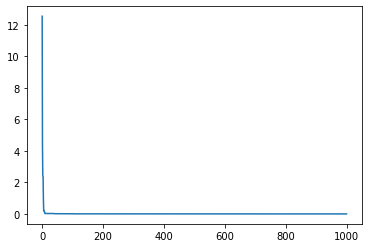

In [5]:
SWARM_SIZE = 50
MAX_ITERS = 1000

# ove brojeve za c_i/l/g trazimo eksperimentalno
# swarm = [Particle(bounds, rastrigin, 0.75, 1, 1) for _ in range(SWARM_SIZE)]
swarm = [Particle(bounds, rosenbrock, 0.75, 1, 1) for _ in range(SWARM_SIZE)]
# npr hocemo da plotujemo kroz iteracije kako se menja vrednost
bestValues = []

for i in range(MAX_ITERS):
    for particle in swarm:
        particle.updateVelocity()
        particle.updatePosition()
        
    bestValues.append(Particle.globalBestValue);
        
print(f'Solution: {Particle.globalBestPosition} value: {Particle.globalBestValue}')

plt.plot(range(MAX_ITERS), bestValues)

# NOTE: interesantna stvar koja moze da nams e desi kod rosenbrocka, zaokruzice ponekad resenje na [1,1]
# ali value nece tacno da zaokruzi na 0 nego ce da bude neki broj sa veoma malim eksponentom
# to je zato sto je gustina floating point brojeva manja oko 1 nego oko 0 (?)